In [9]:
%%time
%matplotlib inline

import importlib
import new_import  

importlib.reload(new_import)


from new_import import *

CPU times: user 75.9 ms, sys: 4.91 ms, total: 80.8 ms
Wall time: 107 ms


In [10]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

client

An existing cluster was found. Connecting to: easihub.dc0ab8caf84946009f96955fe68b8d7a
CPU times: user 26.2 ms, sys: 11.2 ms, total: 37.4 ms
Wall time: 136 ms


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.dc0ab8caf84946009f96955fe68b8d7a/status,


In [13]:
# cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0) 

coordinates = (longtitude_range, latitude_range)

In [14]:
# tải dữ liệu vh vv từ vệ tinh sentinel-1
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)

<xarray.Dataset>
Dimensions:      (time: 33, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [21]:
average_vv = calculate_average(dsvv, time_pattern='2W')
average_vh = calculate_average(dsvh, time_pattern='2W')

In [22]:
average_vv

<xarray.DataArray 'vv' (time: 29, y: 8874, x: 9902)>
dask.array<stack, shape=(29, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-11 2022-09-25 ... 2023-10-08
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [23]:
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [24]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 1.27 s, sys: 44.5 ms, total: 1.31 s
Wall time: 1.31 s


VBox()

In [11]:
# calculate NDVI
dsNDVI = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = dsNDVI["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 295, y: 8874, x: 9902)>
dask.array<truediv, shape=(295, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2021-09-02T03:35:08.446000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648

In [12]:
%%time
# calculate average NDVI
average_ndvi = calculate_average(ndvi,time_pattern="2W")
progress(average_ndvi)

CPU times: user 1.21 s, sys: 6.35 ms, total: 1.22 s
Wall time: 1.21 s


VBox()

In [13]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

In [15]:
dsvv

<xarray.DataArray 'vv' (time: 73, y: 8874, x: 9902)>
dask.array<dc_load_vv, shape=(73, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2021-09-05T22:45:35 ... 2023-09-25T22:...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

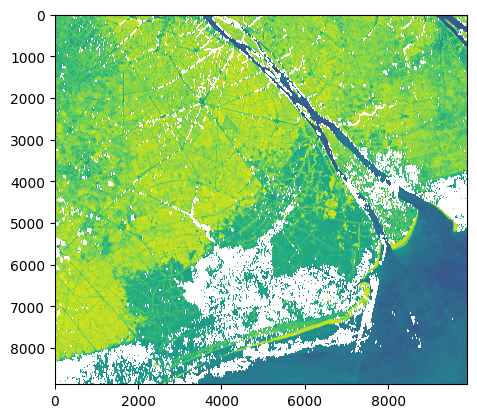

In [17]:
plt.imshow(average_ndvi.isel(time=6), vmin=None, vmax=None)

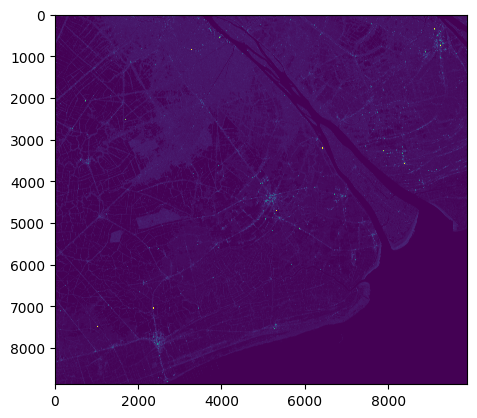

In [15]:
plt.imshow(dsvh.isel(time=6), vmin=0, vmax=1)

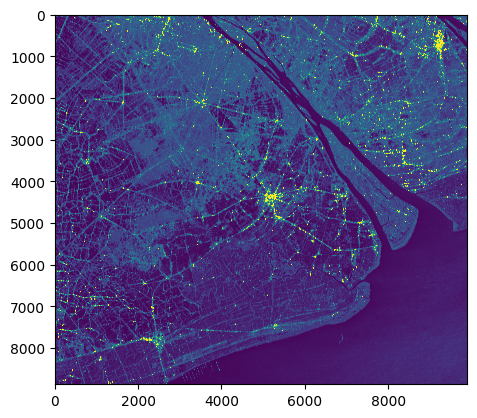

In [18]:
plt.imshow(dsvv.isel(time=6), vmin=0, vmax=1)

In [19]:
mask = ~np.isnan(average_ndvi)

X_train = np.stack([average_vh.values[mask], average_vv.values[mask]], axis=1)
y_train = average_ndvi.values[mask]

In [ ]:
import matplotlib.pyplot as plt

# Lấy dữ liệu VH và VV từ X_train
VH = X_train[:, 0]
VV = X_train[:, 1]

# Vẽ biểu đồ phân tán cho VH và VV
plt.figure(figsize=(8, 6))
scatter = plt.scatter(VH, VV, c=y_train, cmap='viridis', marker='o')
plt.colorbar(scatter, label='NDVI')
plt.xlabel('VH')
plt.ylabel('VV')
plt.title('Scatter plot of VH vs VV colored by NDVI')
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Tạo biểu đồ 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Vẽ biểu đồ 3D cho VH, VV và NDVI
scatter = ax.scatter(VH, VV, y_train, c=y_train, cmap='viridis', marker='o')
ax.set_xlabel('VH')
ax.set_ylabel('VV')
ax.set_zlabel('NDVI')

# Thêm thanh màu để thấy giá trị NDVI
fig.colorbar(scatter, label='NDVI')
plt.title('3D Scatter plot of VH, VV and NDVI')
plt.show()


In [18]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Kiểm tra kích thước của các tập dữ liệu
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_train shape: {X_train.shape}")

X_train shape: (603670296, 2)
X_test shape: (150917574, 2)
y_train shape: (603670296,)
y_test shape: (150917574,)
X_train shape: (603670296, 2)


In [19]:
fill_nan_model = LinearRegression()
fill_nan_model.fit(X_train, y_train)

LinearRegression()

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

# Initialize your model
fill_nan_model = LinearRegression()

# Set up RepeatedKFold cross-validator
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)  # 10 iterations in total (5 splits * 2 repeats)

# List to store validation results
validation_scores = []

# Perform 10 random splits
for train_index, valid_index in rkf.split(X_train):
    # Split into training and validation sets
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
    
    # Train the model on this fold
    fill_nan_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = fill_nan_model.predict(X_valid_fold)
    
    # Evaluate the model (using Mean Squared Error as an example metric)
    score = mean_squared_error(y_valid_fold, y_pred)
    
    # Store the score
    validation_scores.append(score)

# Print the validation results
print(f"Validation scores over 10 splits: {validation_scores}")
print(f"Mean validation score: {sum(validation_scores) / len(validation_scores)}")


Validation scores over 10 splits: [5096.1377, 411.06036, 7.741147, 252.079, 32486.672, 1497.6721, 36462.17, 261.2124, 21.06376, 11.691826]
Mean validation score: 7650.750205898285


In [ ]:

joblib.dump(fill_nan_model, 'fill_nan_model.pkl')

In [26]:
y_pred = fill_nan_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.17703095078468323


In [20]:
X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)

average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)
average_ndvi_filled.values[~mask] = fill_nan_model.predict(X_pred)

In [18]:
X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)
average_ndvi.values[~mask] = fill_nan_model.predict(X_pred)

In [19]:
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

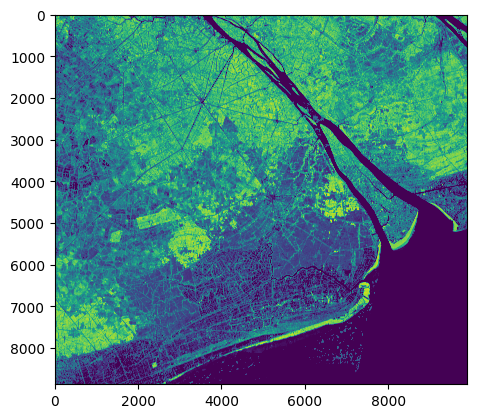

In [21]:
plt.imshow(average_ndvi_filled.isel(time=6), vmin=0, vmax=1)

In [20]:
# for idx, point in average_vh.iterrows():
#     print(point)
    
average_vh.x
    

<xarray.DataArray 'x' (x: 9902)>
array([554795., 554805., 554815., ..., 653785., 653795., 653805.])
Coordinates:
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:       metre
    resolution:  10.0
    crs:         EPSG:32648

In [11]:
train_path = "train/ST_training data_updated_1130points.shp"
train = load_data_geo(train_path)
train

,No,X,Y,LU2022,Hientrang,HT_code,geometry
0,1.0,603860.819,1081162.862,Pomelo,CLN,5,POINT (603860.819 1081162.862)
1,2.0,601306.410,1082782.940,Pomelo,CLN,5,POINT (601306.410 1082782.940)
2,3.0,601084.510,1081351.870,Pomelo,CLN,5,POINT (601084.510 1081351.870)
3,4.0,602193.760,1079205.220,Pomelo,CLN,5,POINT (602193.760 1079205.220)
4,5.0,602459.000,1080946.000,Pomelo,CLN,5,POINT (602459.000 1080946.000)
5,6.0,603696.934,1080684.227,Pomelo,CLN,5,POINT (603696.934 1080684.227)
6,7.0,604156.740,1079731.010,Pomelo,CLN,5,POINT (604156.740 1079731.010)
7,8.0,628664.000,1068413.000,Pomelo,CLN,5,POINT (628664.000 1068413.000)
8,9.0,629930.000,1067206.000,Pomelo,CLN,5,POINT (629930.000 1067206.000)
9,11.0,633632.000,1063529.000,Pomelo,CLN,5,POINT (633632.000 1063529.000)


In [6]:
datasets = get_data_sen1_and_sen2(train, average_ndvi_filled, average_vh, average_vv)

NameError: name 'train' is not defined

In [7]:
# cấu hình nhãn dữ liệu
label_mapping = {
    "Lua tom": "0",
    "Lua": "1",
    "CHN": "2",
    "CLN": "3",
    "TS": "4",
    "Song": "5",
    "Dat xay dung": "6",
    "Rung": "7"
}

# chia tập dữ liệu train, val, test
X_train, X_val, X_test, y_train, y_val, y_test = split_train_data(train, label_mapping, datasets)

NameError: name 'train' is not defined

In [8]:
# Huấn luyện mô hình
best_model = find_best_model(dataset = (X_train, X_val, y_train, y_val))

NameError: name 'X_train' is not defined

In [33]:
# kiểm tra độ chính xác với tập test
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 91.0 %


In [34]:
# Lưu mô hình huấn luyện
save_model("best_model.joblib", best_model)

Done!


In [35]:
# đóng client, cluster
client.close()
cluster.close()